###Cloning Repository

In [ ]:
!git clone https://github.com/giwilorjelly/hackerearth_shell.ai_hackathon
!unzip /content/hackerearth_shell.ai_hackathon/shell.ai_dataset.zip -d /content/hackerearth_shell.ai_hackathon
!unzip /content/hackerearth_shell.ai_hackathon/Shell_Hackathon_Dataset.zip -d /content/hackerearth_shell.ai_hackathon
!unzip /content/hackerearth_shell.ai_hackathon/Wind_Farm_Evaluator.zip -d /content/hackerearth_shell.ai_hackathon

Cloning into 'hackerearth_shell.ai_hackathon'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6 (delta 1), reused 4 (delta 1), pack-reused 0
Unpacking objects: 100% (6/6), done.
Archive:  /content/hackerearth_shell.ai_hackathon/shell.ai_dataset.zip
  inflating: /content/hackerearth_shell.ai_hackathon/Shell_Hackathon_Dataset.zip  
  inflating: /content/hackerearth_shell.ai_hackathon/Wind_Farm_Evaluator.zip  
  inflating: /content/hackerearth_shell.ai_hackathon/aep_algo.pdf  
  inflating: /content/hackerearth_shell.ai_hackathon/data_interpret.pdf  
  inflating: /content/hackerearth_shell.ai_hackathon/prob-statement.pdf  
  inflating: /content/hackerearth_shell.ai_hackathon/wake_model.pdf  
Archive:  /content/hackerearth_shell.ai_hackathon/Shell_Hackathon_Dataset.zip
   creating: /content/hackerearth_shell.ai_hackathon/Shell_Hackathon Dataset/
  inflating: /content/hackerearth_shell.ai_hackat

###Importing Script

In [ ]:
#copying script to current directory
from shutil import copyfile
import os
copyfile('/content/hackerearth_shell.ai_hackathon/Farm_Evaluator_Vec.py',
         os.path.join(os.getcwd(),'Farm_Evaluator_Vec.py'))

'/content/Farm_Evaluator_Vec.py'

In [ ]:
import Farm_Evaluator_Vec as fev
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

###Calculating AEP for turbine_loc_test

In [ ]:
turb_rad = 50.0
turb_coords = fev.getTurbLoc('/content/hackerearth_shell.ai_hackathon/Shell_Hackathon Dataset/turbine_loc_test.csv')#turbine locations csv file path
power_curve = fev.loadPowerCurve('/content/hackerearth_shell.ai_hackathon/Shell_Hackathon Dataset/power_curve.csv')#power curve csv file path
wind_inst_freq = fev.binWindResourceData('/content/hackerearth_shell.ai_hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2007.csv')#wind data file name
n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = fev.preProcessing(power_curve)

In [ ]:
aep = fev.getAEP(turb_rad, turb_coords, power_curve, wind_inst_freq, n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t)
print("AEP for turbine_loc_test on wind_data_2007:",aep)

AEP for turbine_loc_test on wind_data_2007: 505.4506365966797


###Functions for Pattern Search

In [ ]:
def penalty(coords,rho1,rho2):
  c = np.copy(coords).reshape(50,2)
  #finding boundary boundary loss
  b_loss = np.sum(np.abs(c[c<50]-50)) + np.sum(np.abs(c[c>3950]-3950))
  #finding proximity loss
  p_loss=0
  for i in range(49):
    for j in range(i+1,50):
      d = np.linalg.norm(c[i][:]-c[j][:])
      if d<400:
        p_loss+=d
  return rho1*b_loss+rho2*p_loss  

In [ ]:
def optimize(turb_coords,aep,step,min_step,step_decay_rate):
  best_aep = aep
  last_aep = aep
  turb_coords = turb_coords.reshape(100)
  rho1 = 10
  rho2 = 10
  directions = np.ones(100)
  temp_coords = np.copy(turb_coords)
  while step>=min_step:
    
    for i in range(100):
      #for direction[i]
      temp_coords[i] += directions[i]*step
      new_aep = fev.getAEP(turb_rad, temp_coords.reshape(50,2), power_curve, wind_inst_freq, n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t)
      new_aep -= penalty(temp_coords,rho1,rho2)
      if new_aep>best_aep:
        best_aep = new_aep
        rho1 *= 1.1
        rho2 *= 1.1
      #for -direction[i]
      else:
        
        directions[i] *= -1
        temp_coords[i] += directions[i]*step
        new_aep = fev.getAEP(turb_rad, temp_coords.reshape(50,2), power_curve, wind_inst_freq, n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t)
        new_aep -= penalty(temp_coords,rho1,rho2)
        '''if new_aep>best_aep:
          best_aep = new_aep
          rho1 *= 1.1
          rho2 *= 1.1'''
        best_aep = new_aep
    if last_aep==best_aep:
      step = step*step_decay_rate
    print(last_aep,"-->",best_aep,'step:',step)
    last_aep = best_aep
  return temp_coords.reshape(50,2)



In [ ]:
def optimize_v2(turb_coords,aep,step,epoch,step_decay_rate):
  step_ini = step
  best_aep = aep
  last_aep = aep
  turb_coords = turb_coords.reshape(100)
  rho1 = 10
  rho2 = 10

  directions = np.ones(100)
  temp_coords = np.copy(turb_coords)
  for e in range(epoch):
    for i in range(100):
      change=0
      while step>0.01:
       #for direction[i]
       temp_coords[i] += directions[i]*step
       new_aep = fev.getAEP(turb_rad, temp_coords.reshape(50,2), power_curve, wind_inst_freq, n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t)
       new_aep -= penalty(temp_coords,rho1,rho2)
       if new_aep>best_aep:
         best_aep = new_aep
         rho1 *= 1.1
         rho2 *= 1.1
         change=0
       #for -direction[i]
       else:
         #print('else',change) --ignore
         directions[i] *= -1
         temp_coords[i] += directions[i]*step
         new_aep = fev.getAEP(turb_rad, temp_coords.reshape(50,2), power_curve, wind_inst_freq, n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t)
         new_aep -= penalty(temp_coords,rho1,rho2)
         best_aep = new_aep
         change+=1
       print('\r','aep:',best_aep,'i:',i,'step:',step,end='')
       if change==2: #no change on switching directions twice
         step*=step_decay_rate
         change=0
       #print('aep:',best_aep,step)
      #reinitialize step for next position i
      step = step_ini
    print('\r',last_aep,"-->",best_aep, 'epoch:',e+1,'         ')
    if last_aep==best_aep:
      print('No further optimization possible')
      break
    last_aep = best_aep
  return temp_coords.reshape(50,2)



In [ ]:
new_coords=optimize_v2(turb_coords,505.4506365966797,100,10,0.5)
print(penalty(new_coords,10,10))

In [ ]:
_=fev.checkConstraints(new_coords,100)

Both perimeter and proximity constraints are satisfied !!



###Visualizing Changes

In [ ]:
def visualize(old_coords,new_coords,figsize=(10,10)):
  fig = plt.figure(figsize=figsize)
  fig = plt.scatter(old_coords[:,0],old_coords[:,1],c='red')
  fig = plt.scatter(new_coords[:,0],new_coords[:,1],c='blue')
  plt.show()

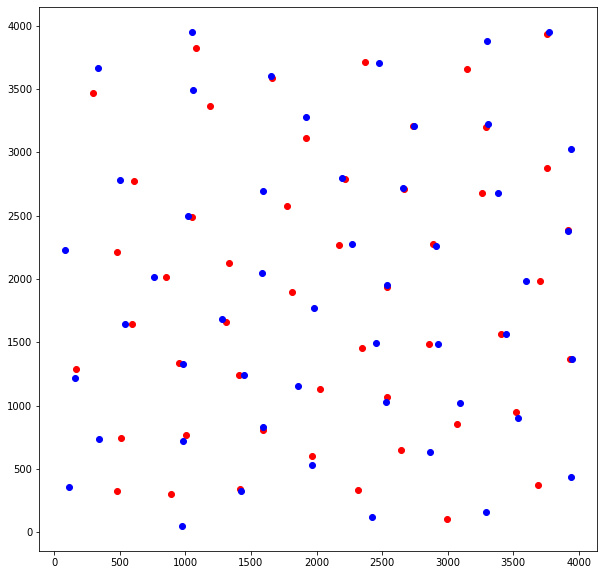

In [ ]:
visualize(turb_coords,new_coords)

###Optimizing for Entire Dataset

In [ ]:
wind_data_files = []
for root, dirs, files in os.walk('/content/hackerearth_shell.ai_hackathon/Shell_Hackathon Dataset/Wind Data/'):
  for name in files:
    filepath = os.path.join(root,name)
    print(filepath)
    wind_data_files.append(filepath)

df_list = [pd.read_csv(fp) for fp in wind_data_files]


/content/hackerearth_shell.ai_hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2013.csv
/content/hackerearth_shell.ai_hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2015.csv
/content/hackerearth_shell.ai_hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2014.csv
/content/hackerearth_shell.ai_hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2017.csv
/content/hackerearth_shell.ai_hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2009.csv
/content/hackerearth_shell.ai_hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2008.csv
/content/hackerearth_shell.ai_hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2007.csv


In [ ]:
for i in range(1,7):
  df_list[0]=df_list[0].append(df_list[i])
df_list = df_list[0]
df_list.to_csv('wind_data_combined.csv')
df_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113113 entries, 0 to 15547
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    113113 non-null  object 
 1   drct    113113 non-null  float64
 2   sped    113113 non-null  float64
dtypes: float64(2), object(1)
memory usage: 3.5+ MB


In [ ]:
wind_inst_freq = fev.binWindResourceData('wind_data_combined.csv')
sum(wind_inst_freq)

0.9999999978808773

In [ ]:
turb_rad = 50.0
turb_coords = fev.getTurbLoc('/content/hackerearth_shell.ai_hackathon/Shell_Hackathon Dataset/turbine_loc_test.csv')#turbine locations csv file path
power_curve = fev.loadPowerCurve('/content/hackerearth_shell.ai_hackathon/Shell_Hackathon Dataset/power_curve.csv')#power curve csv file path
wind_inst_freq = fev.binWindResourceData('/content/hackerearth_shell.ai_hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2017.csv')#wind data file name
n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = fev.preProcessing(power_curve)
aep = fev.getAEP(turb_rad, turb_coords, power_curve, wind_inst_freq, n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t)
print("AEP for Dataset",aep)

AEP for Dataset 545.5921376037597


In [ ]:
aep = fev.getAEP(turb_rad, turb_coords, power_curve, wind_inst_freq, n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t)
print(aep)

545.5921376037597


In [41]:
new_coords=optimize_v2(turb_coords,aep,step=2000,epoch=10,step_decay_rate=.7)#.9
print(penalty(new_coords,10,10))

 545.5921376037597 --> 565.1308767700195 epoch: 1          
 565.1308767700195 --> 568.3082748413086 epoch: 2          
 568.3082748413086 --> 569.1451638793945 epoch: 3          
 569.1451638793945 --> 570.1008828735352 epoch: 4          
 570.1008828735352 --> 570.3728952026368 epoch: 5          
 570.3728952026368 --> 570.5487341308594 epoch: 6          
 570.5487341308594 --> 570.5895025634766 epoch: 7          
 570.5895025634766 --> 570.5945150756836 epoch: 8          
 570.5945150756836 --> 570.6566033935546 epoch: 9          
 570.6566033935546 --> 570.6671630859375 epoch: 10          
0.0


In [ ]:
_=fev.checkConstraints(new_coords,100)

In [ ]:
visualize(turb_coords,new_coords)

###Saving Output for Submission

In [ ]:
df_v11 = pd.DataFrame(data=new_coords,columns=['x','y'])
df_v11.head()

,x,y
0,3928.361328,50.445068
1,3384.406738,2570.833008
2,52.742676,50.730957
3,2033.829102,1128.719971
4,61.678467,989.684082


In [ ]:
df_v11.to_csv('submission_v11.csv',index=False)